In [0]:
import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from IPython import display

### Utils

In [0]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(*args, **kwargs)
        self.__dict__ = self

    def print_(self):
        print(f"{'=' * 80}\n{'Opts'.center(80)}\n{'-' * 80}")
        for key in self:
            if self[key]:
                print('{:>30}: {:<30}'.format(key, self[key]).center(80))
        print('=' * 80)

### Load dataset

In [0]:
def load_dataset(opts):
    (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
    N = train_images.shape[0]   # number of sample
    train_images = train_images.reshape(N, 28, 28, 1).astype('float32')
    train_images = train_images / 255.0 # Normalize the images to [0, 1]

    train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(N).batch(opts.batch_size)
    return train_dataset

### Generator

In [0]:
def add_upconv2D(model, out_channel=1, kernel_size=(5,5), padding="same", upconv=True, batch_norm=True, ReLu=True, conv=True):
    if conv:
        model.add(layers.Conv2DTranspose(out_channel, 
                                        kernel_size,
                                        strides=(2, 2) if upconv else (1, 1),
                                        padding=padding,
                                        use_bias=False))
    if batch_norm:
        model.add(layers.BatchNormalization())
    if ReLu:
        model.add(layers.LeakyReLU())


def get_generator(noise_size):
    G = tf.keras.Sequential()
    G.add(layers.Dense(7*7*256, 
                           use_bias=False, input_shape=(noise_size,)))
    
    G.add(layers.Reshape((7, 7, 256)))
    add_upconv2D(G, conv=False, batch_norm=True, ReLu=True)
    add_upconv2D(G, out_channel=128, kernel_size=(5,5), padding="same", upconv=False, batch_norm=True, ReLu=True, conv=True)
    add_upconv2D(G, out_channel=64, kernel_size=(5,5), padding="same", upconv=True, batch_norm=True, ReLu=True, conv=True)
    add_upconv2D(G, out_channel=1, kernel_size=(5,5), padding="same", upconv=True, batch_norm=True, ReLu=True, conv=True)
    
    assert G.output_shape == (None, 28, 28, 1)
    return G

In [0]:
def plot_G_noise(G, noise):
    fake_img = G(noise, training=False)
    plt.imshow(fake_img[0, :, :, 0]*255.0, cmap='gray')
    plt.show()

### Discriminator

In [0]:
def add_conv(model, out_channel=1, kernel_size=(5, 5), stride=(2, 2), padding='same', ReLu=True, dropout=None, conv=True):
    if conv:
        model.add(layers.Conv2D(out_channel, kernel_size, strides=stride, padding=padding))
    if ReLu:
        model.add(layers.LeakyReLU())
    if dropout:
        model.add(layers.Dropout(dropout))

def get_discriminator():
    D = tf.keras.Sequential()
    D.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    add_conv(D, conv=False, ReLu=True, dropout=0.3)
    add_conv(D, out_channel=128, kernel_size=(5, 5), stride=(2, 2), padding='same', ReLu=True, dropout=0.3)
    add_conv(D, out_channel=256, kernel_size=(5, 5), stride=(2, 2), padding='same', ReLu=True, dropout=0.3)
    
    D.add(layers.Flatten())    
    D.add(layers.Dense(1))
    return D

### Training Loop

In [0]:
# define losses
ce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def get_G_D(opts):
    G = get_generator(opts.g_noise_size)
    D = get_discriminator()
    return G, D

def d_loss(real_img, fake_img):
    real_loss = ce(tf.ones_like(real_img), real_img)
    fake_loss = ce(tf.zeros_like(fake_img), fake_img)
    return real_loss + fake_loss

def g_loss(fake_pred):
    return ce(tf.ones_like(fake_pred), fake_pred)

def get_optimizers(opts):
    G_optim = tf.keras.optimizers.Adam(opts.g_lr)
    D_optim = tf.keras.optimizers.Adam(opts.d_lr)
    return G_optim, D_optim

@tf.function
def training_loop(G, D, G_optim, D_optim, batch, opts):
    noise_sample = tf.random.normal([opts.batch_size, opts.g_noise_size])

    with tf.GradientTape() as G_tape, tf.GradientTape() as D_tape:
        fake_img = G(noise_sample, training=True)

        real_pred = D(batch, training=True)
        fake_pred = D(fake_img, training=True)
        G_loss = g_loss(fake_pred)
        D_loss = d_loss(real_pred, fake_pred)
    
    G_grad = G_tape.gradient(G_loss, G.trainable_variables)
    D_grad = D_tape.gradient(D_loss, D.trainable_variables)
    G_optim.apply_gradients(zip(G_grad, G.trainable_variables))
    D_optim.apply_gradients(zip(D_grad, D.trainable_variables))

def train_model(opts):
    G, D = get_G_D(opts)
    G_optim, D_optim = get_optimizers(opts)
    dataset = load_dataset(opts)

    fix_noise = tf.random.normal([opts.num_fix_samples, opts.g_noise_size])

    for epoch in range(opts.epochs):
        
        for batch in dataset:
            try:
                training_loop(G, D, G_optim, D_optim, batch, opts)
            except KeyboardInterrupt:
                print('Exiting early from training.')
                return G, D
        display.clear_output(wait=True)
        plot_G_noise(G, fix_noise)
    return G, D

### Train

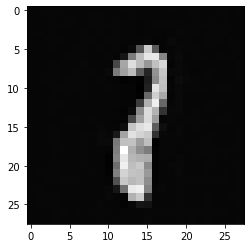

In [0]:
args = AttrDict()
args_dict = {
            'image_size':32,  
            'image_channel':1,
            'g_noise_size':100,
            'num_fix_samples':1,
            # 'opt_lr':0.0003,
            'g_lr':0.001,
            'd_lr':0.001,
            # 'opt_beta1':0.5,
            # 'opt_beta2':0.999,
            'batch_size':32, 
            'sample_dir': 'samples_gan',
            'log_step':200,
            'sample_every':200,
            'epochs':50}

args.update(args_dict)
args.print_()
G, D = train_model(args)